 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# Case example 1. Germ-somatic communication dynamics during ovarian development

This case study combines:
- CellphoneDB method 3 
- microenvironments (from Spatial Transcriptomics)
- CellSign modules (TF activities derived from scATAC-seq) 

to predict cell-cell interactions specific to each "differentiation timepoint of human germ cells into oocytes". See Garcia-Alonso et al 2022 “The second wave of pre-granulosa cells” section for more details. 

**Biological background.** Germ cells and somatic cells synchronise their differentiation using local paracrine factors (Supplementary Figure 1a) in the developing ovary. Single cell transcriptomics analysis revealed four somatic supporting cell states (OSE, preGC-IIa, preGC-IIb and GC) and five germ cell states (PGCs, GCs, oogonia, oogonia-meiotic, oocyte). Spatial transcriptomics analysis revealed a gradient of differentiation (from undifferentiated cells in the cortex to differentiated cells in the medulla) that we discretized into three microenvironments matching the cell differentiation stages (Supplementary Figure 1b-c).

**Research question.** __What are the cell-cell interactions changing along the differentiation trajectory?__
        NOTE there will be germ-somatic interactions constant along the trajectory but we are after those interactions showing a dynamic pattern and could trigger cell identity changes or push differentiation forwards. 
        Also NOTE that there are more cell types in the ovary (for example, stromal, immune, endothelial), but we are going to restrict the analysis to these two lineages because (i) they are in direct contact with each other; and (ii) they have synchronised differentiation.

This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. In this notebook we will explain how to run CellphoneDB for the **differential expression method**.

#### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) 
[GCC 12.3.0]


___
## Input files


Here we aim to retrieve cell-cell interactions involving genes upregulated by any germ or somatic cell state along their differentiation trajectory, with CellPhoneDB method 3. Beside the mandatory dataset's counts and meta files (described [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#input-files) ), we will provide the following, which configuration is tailored towards our biological question.


- **DEGs file** (mandatory for CellphoneDB method 3), which contains the genes overexpressed by any cell state in any of the two differentiation trajectories (i.e. the germ trajectory and the somatic trajectory). DEGs were calculated using a one-sided Wilcoxon Rank Sum test implemented in the FindAllMarkers function with Seurat v.3.2.2 in a “one versus rest-of-the-lineage” fashion.
>Critical step.
To capture subtle expression differences along each lineage trajectory (the somatic and the germinal), we need to compare each cell state against the other cell states of the same lineage-trajectory in a “one versus rest-of-the-lineage” fashion (i.e. hierarchical differential expression analysis). 
Why “one versus rest-of-the-lineage” and not “one versus all-the-rest”? Because “one versus all-the-rest” does not distinguish cell state-specific from lineage-specific upregulated genes - Here we want to specifically target ligands/receptors upregulated by a specific cell state along their differentiation trajectory, thus our reference should be the cells in the differentiation trajectory (”rest-of-the-lineage”) and not the cells from other lineages (“all-the-rest” including all immune, endothelial, somatic and germ cells together).
- **Microenvironments file.** Because two cells can only interact paracrinally if they colocalise in space and time, we will inform CellphoneDB about the cellular composition of each of the three ovarian microenvironments. CellphoneDB will use this information to restrict the analysis to those cell types that co-localise in each microenvironment (i.e. discard interactions between cells that never co-localise). These spatial niches were identified via spatial transcriptomics analysis where Visium Spatial transcriptomics spots were deconvoluted into single cell type densities using cell2location. 
- **TF activity file.** Because we had matched scATAC-seq data in this study, we used chromatin accessibility to estimate TF binding activity and identify active TF. CellphoneDB will use cell state TF activity to prioritise cell-cell interactions where the cell expressing the receptor has also the downstream directly-regulated TF active. In this study, TF activity was estimated from (i) calculating TF motif binding scores with chromVar v.1.12.2 using TF positional weight matrices from JASPAR v2018, HOCOMOCO v10, SwissRegulon, and HOMER, which returns a matrix with TF binding activity per cell, and then (ii) estimating differential TF binding activity between cell states in a “one versus rest-of-the-lineage” fashion using one-sided Wilcoxon Rank Sum test implemented in the FindAllMarkers function with Seurat v.3.2.2. 

In [3]:
# Our base directory for the analysis
os.chdir('/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample1_differentiation/')

# Path to our input files
cpdb_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/v5.0.0/cellphonedb.zip'
meta_file_path = 'input/dataset_meta.tsv'
counts_file_path = 'input/dataset_counts_normloqTransformed.h5ad'
microenvs_file_path = 'input/microenvironments.tsv'
degs_file_path = 'input/DEGs_upregulated_genes.tsv'
active_tf_path = 'input/active_TFs.tsv'
out_path = 'results/'

<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,Cell,cell_type
0,FCA_GND8047885_AAAGCAAAGAGCAATT,Somatic.preGC_IIa
1,FCA_GND8047885_AAAGCAAGTTATCCGA,Somatic.preGC_IIa
2,FCA_GND8047885_AACCATGAGCCGTCGT,Somatic.preGC_IIa


<span style="color:green">**2)**</span>  The **counts** files is a h5ad object from scanpy. The dimensions and order of this object must coincide with the dimensions of the metadata file, i.e. must have the same number of cells in both files.

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(6642, 28820)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['Cell']) \
    .sort()

True

<span style="color:green">**3)**</span> **Differentially expressed genes** file s is a two columns file indicanting which gene up-regulated (or specific) in a cell type. The **first column** corresponds to the cluster name (these match with those in the metadata file) and the **second column** the up-regulated gene. The remaining columns are ignored by CellphoneDB. All genes present in this file will be taken into account, thus the user must provide in this file only those genes considered as up-regulated or relevant for the analysis.

In [7]:
pd.read_csv(degs_file_path, sep = '\t').head(3)

,cluster,gene,p_val_adj,p_val,avg_logFC,pct.1,pct.2
0,Germ.PGC,NANOG,0.000000e+00,0.000000e+00,1.470085,0.866,0.055
1,Germ.PGC,IFITM1,1.591824e-246,8.953896e-251,1.250128,0.803,0.081
2,Germ.PGC,ETV4,8.285905e-224,4.660763e-228,1.035607,0.759,0.080


In [8]:
# How many DEGs each cell type has?
print(pd.read_csv(degs_file_path, sep = '\t')['cluster'].value_counts())

cluster
Germ.oocyte             415
Somatic.granulosa       240
Germ.oogonia_meiotic    233
Germ.PGC                178
Somatic.OSE              95
Germ.oogonia_STRA8       31
Somatic.preGC_IIb        29
Somatic.preGC_IIa        10
Name: count, dtype: int64


<span style="color:green">**4)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironment. CellphoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining three spatial microenvionments.

In [9]:
microenv = pd.read_csv(microenvs_file_path,
                       sep = '\t')
microenv.head(3)

,celltype,microenvironment
0,Germ.PGC,Cortex_outer
1,Somatic.OSE,Cortex_outer
2,Somatic.preGC_IIa,Cortex_outer


Displaying cells grouped per microenvironment

In [10]:
microenv.groupby('microenvironment')['celltype'].apply(lambda x : list(x.value_counts().index))

microenvironment
Cortex_inner         [Germ.oogonia_STRA8, Germ.oogonia_meiotic, Som...
Cortex_outer                [Germ.PGC, Somatic.OSE, Somatic.preGC_IIa]
Medulla_follicles                     [Germ.oocyte, Somatic.granulosa]
Name: celltype, dtype: object

<span style="color:green">**5)**</span> **Active transcription factors** defines trancription factors active in a given cell type.

In [11]:
pd.read_csv(active_tf_path, sep = '\t').head(3)

,cluster,TF
0,Germ.oocyte,HEY2
1,Germ.oocyte,RORA
2,Germ.oocyte,STAT1


____
## Run CellphoneDB with differential analysis (method 3)
The output of this method will be saved in `output_path` and also assigned to the predefined variables.

In [12]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method

cpdb_results = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,                      # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
    score_interactions = False,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )

[ ][CORE][25/06/24-10:34:48][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
input/dataset_counts_normloqTransformed.h5ad
input/dataset_meta.tsv
input/microenvironments.tsv
input/active_TFs.tsv
input/DEGs_upregulated_genes.tsv
[ ][CORE][25/06/24-10:34:53][INFO] Running Real Analysis
[ ][CORE][25/06/24-10:34:53][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][25/06/24-10:34:53][INFO] Running DEGs-based Analysis
[ ][CORE][25/06/24-10:34:53][INFO] Building results
Saved deconvoluted to results/degs_analysis_deconvoluted_06_25_2024_103453.txt
Saved deconvoluted_percents to results/degs_analysis_deconvoluted_percents_06_25_2024_103453.txt
Saved means to results/degs_analysis_means_06_25_2024_103453.txt
Saved relevant_interactions to results/degs_analysis_relevant_interactions_06_25_2024_103453.txt
Saved significant_means to results/degs_analysis_significant_means_06_25_2024_103453.txt
Save

____
## Results & Outputs

Results are save as files and as a dictionary in the `cpdb_results` variable.

These are the different tables generated. For a full explanation of the outputs, check the documentation [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#output-files).

In [13]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'relevant_interactions',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted']

#### Explore CellphoneDB outputs

This function allows to filter CellphoneDB results by specifying: cell types pairs, genes or specific interactions.

In **this example** we are going to filter interactions within the cells in the medulary follicles microenvironemt involved in Notch signalling.

In [14]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['Germ.oocyte'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['Somatic.granulosa'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = [''],                                       # filter interactions based on the genes participating (list).
#     query_interactions = [''],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    query_classifications = ['Signaling by Notch']
)

search_results.head(3)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
0,JAG1_NOTCH1,simple:P78504,simple:P46531,JAG1,NOTCH1,Ligand-Receptor,Signaling by Notch,Germ.oocyte|Somatic.granulosa,1.636
1,DLL3_NOTCH3,simple:Q9NYJ7,simple:Q9UM47,DLL3,NOTCH3,Ligand-Receptor,Signaling by Notch,Germ.oocyte|Somatic.granulosa,1.478
2,JAG1_NOTCH2,simple:P78504,simple:Q04721,JAG1,NOTCH2,Ligand-Receptor,Signaling by Notch,Germ.oocyte|Somatic.granulosa,2.186


> From the results, we can see that several nocth interactions are upregulated between Germ.oocyte|Somatic.granulosa celltype pair, with the ligand being secreted by the oocytes.

## Plotting

Cell-cell interaction data can be plotted in multiple way; chord plots/heatmaps describing the number of relevant interactions found between pairs of cells or dot plots denoting the specific partners and interacting cells among others. See (Armingol et al 2021 review)[https://www.nature.com/articles/s41576-020-00292-x/figures/4].

Here we use ktplotspy ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellphoneDB outputs.

In [15]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

#### Summary plots

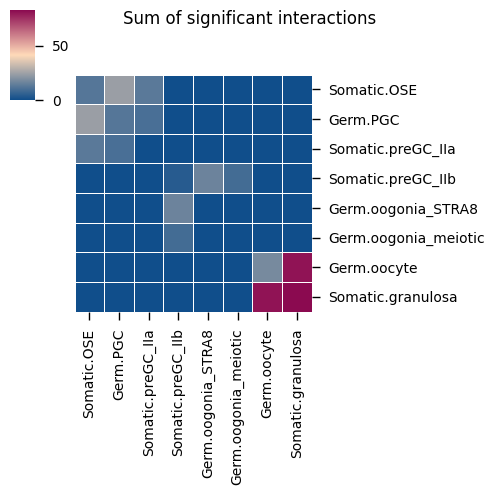

In [16]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      figsize=(5, 5),
                      title="Sum of significant interactions")

> NOTE: most relevant interactions (involving a gene in DEGs) occur between oocytes and granulosa. This is not surprising as both granulosa and oocytes are terminal differentiation states and upregulate a significant number of genes (see the DEG file) compared to their somatic or germ cell predecessors.

In [17]:
# How many DEGs each cell type has?
print(pd.read_csv(degs_file_path, sep = '\t')['cluster'].value_counts())

cluster
Germ.oocyte             415
Somatic.granulosa       240
Germ.oogonia_meiotic    233
Germ.PGC                178
Somatic.OSE              95
Germ.oogonia_STRA8       31
Somatic.preGC_IIb        29
Somatic.preGC_IIa        10
Name: count, dtype: int64


Or plot a heatmap per microenvironment

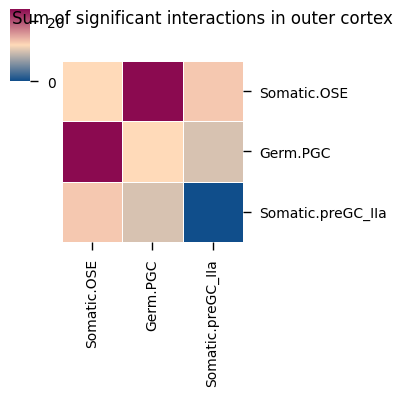

In [18]:
d_microenv = microenv.groupby('microenvironment')['celltype'].apply(lambda x : list(x.value_counts().index))

kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      cell_types=d_microenv['Cortex_outer'],
                      figsize=(4, 4),
                      title="Sum of significant interactions in outer cortex")

> NOTE: It looks that within this tissue niche, there are more interactiosn between PGC-OSE than PGC-preGC_IIa. What are these interactions?

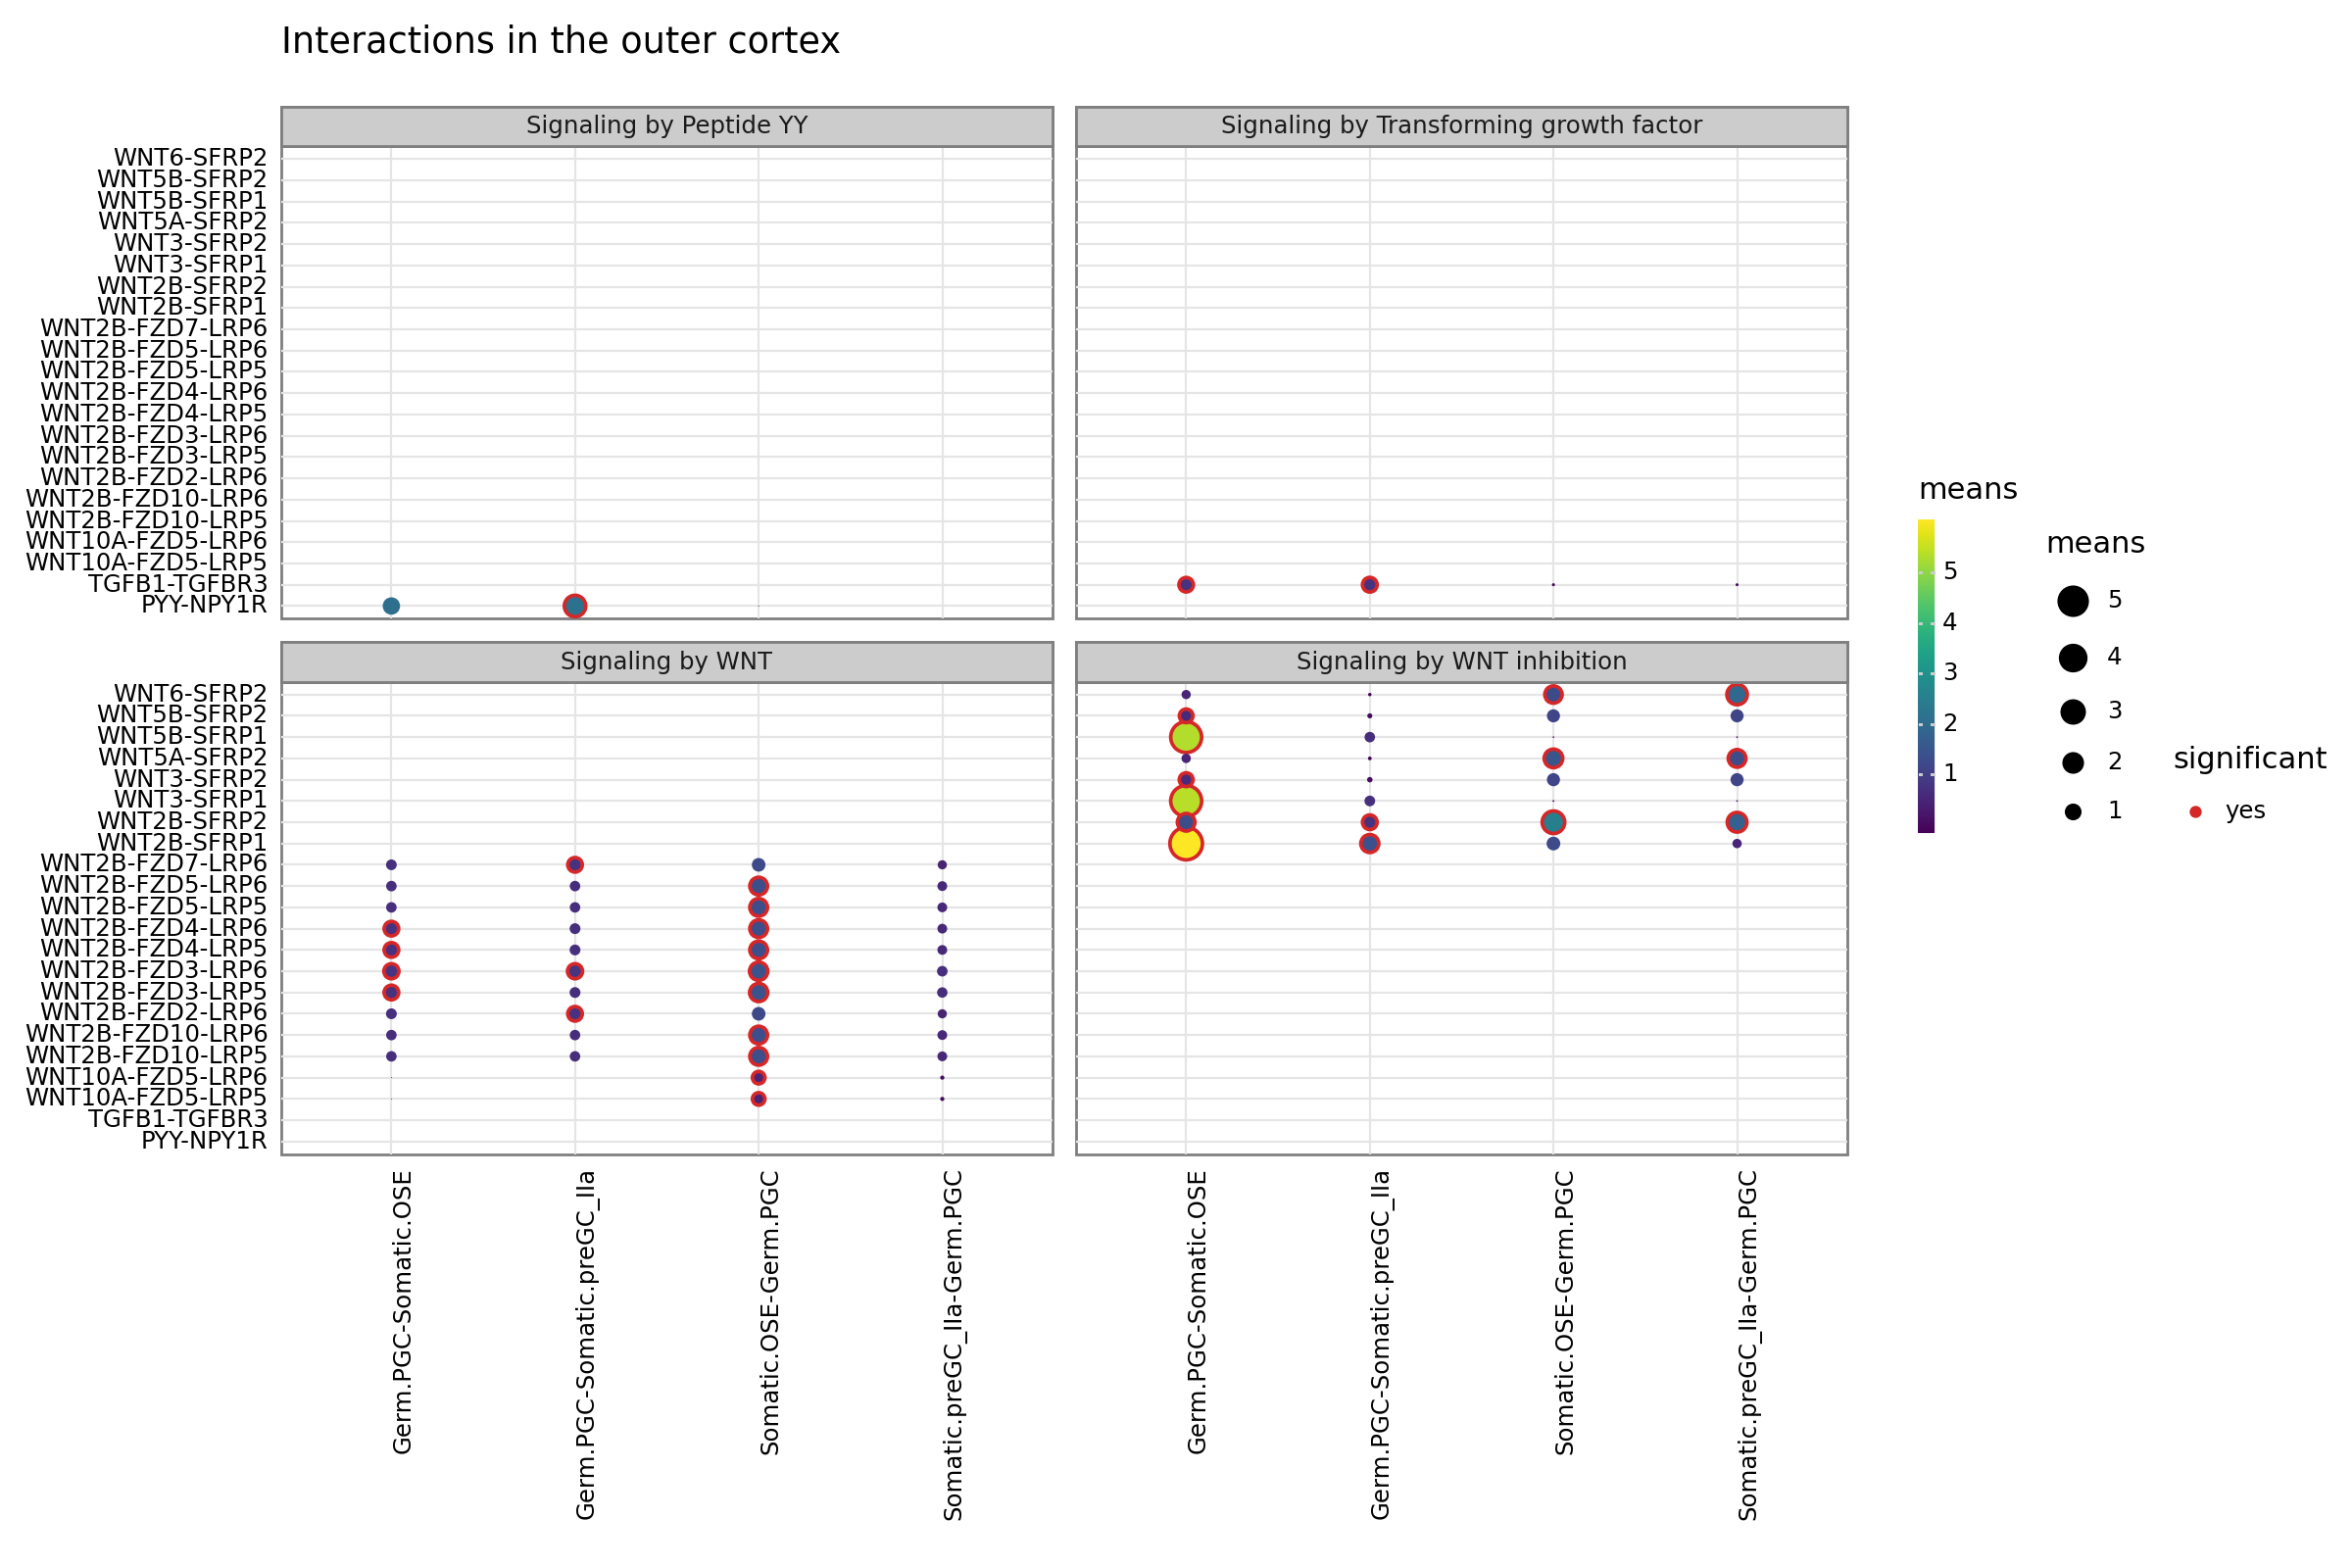

<Figure Size: (1200 x 800)>

In [19]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Somatic.OSE|Somatic.preGC_IIa",
    cell_type2 = "Germ.PGC", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
#     genes = ["JAG1"],
    figsize = (12, 8),
    title = "Interactions in the outer cortex",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False
)

p + facet_wrap("~ classification", ncol = 2)

> It looks like Somatic.OSE and Somatic.preGC_IIa are useing a different code of WNT signalling.

### Detailed plots

Let's see what are the interactions between oocytes and granulosa cells in the medullary follicles.

We will do so with Dotplots to visualise the average expression of the interacting molecules (colour of dots) and at the same time its relevance (red stroke - if the interaction contains a differentially expressed gene from the DEG file).

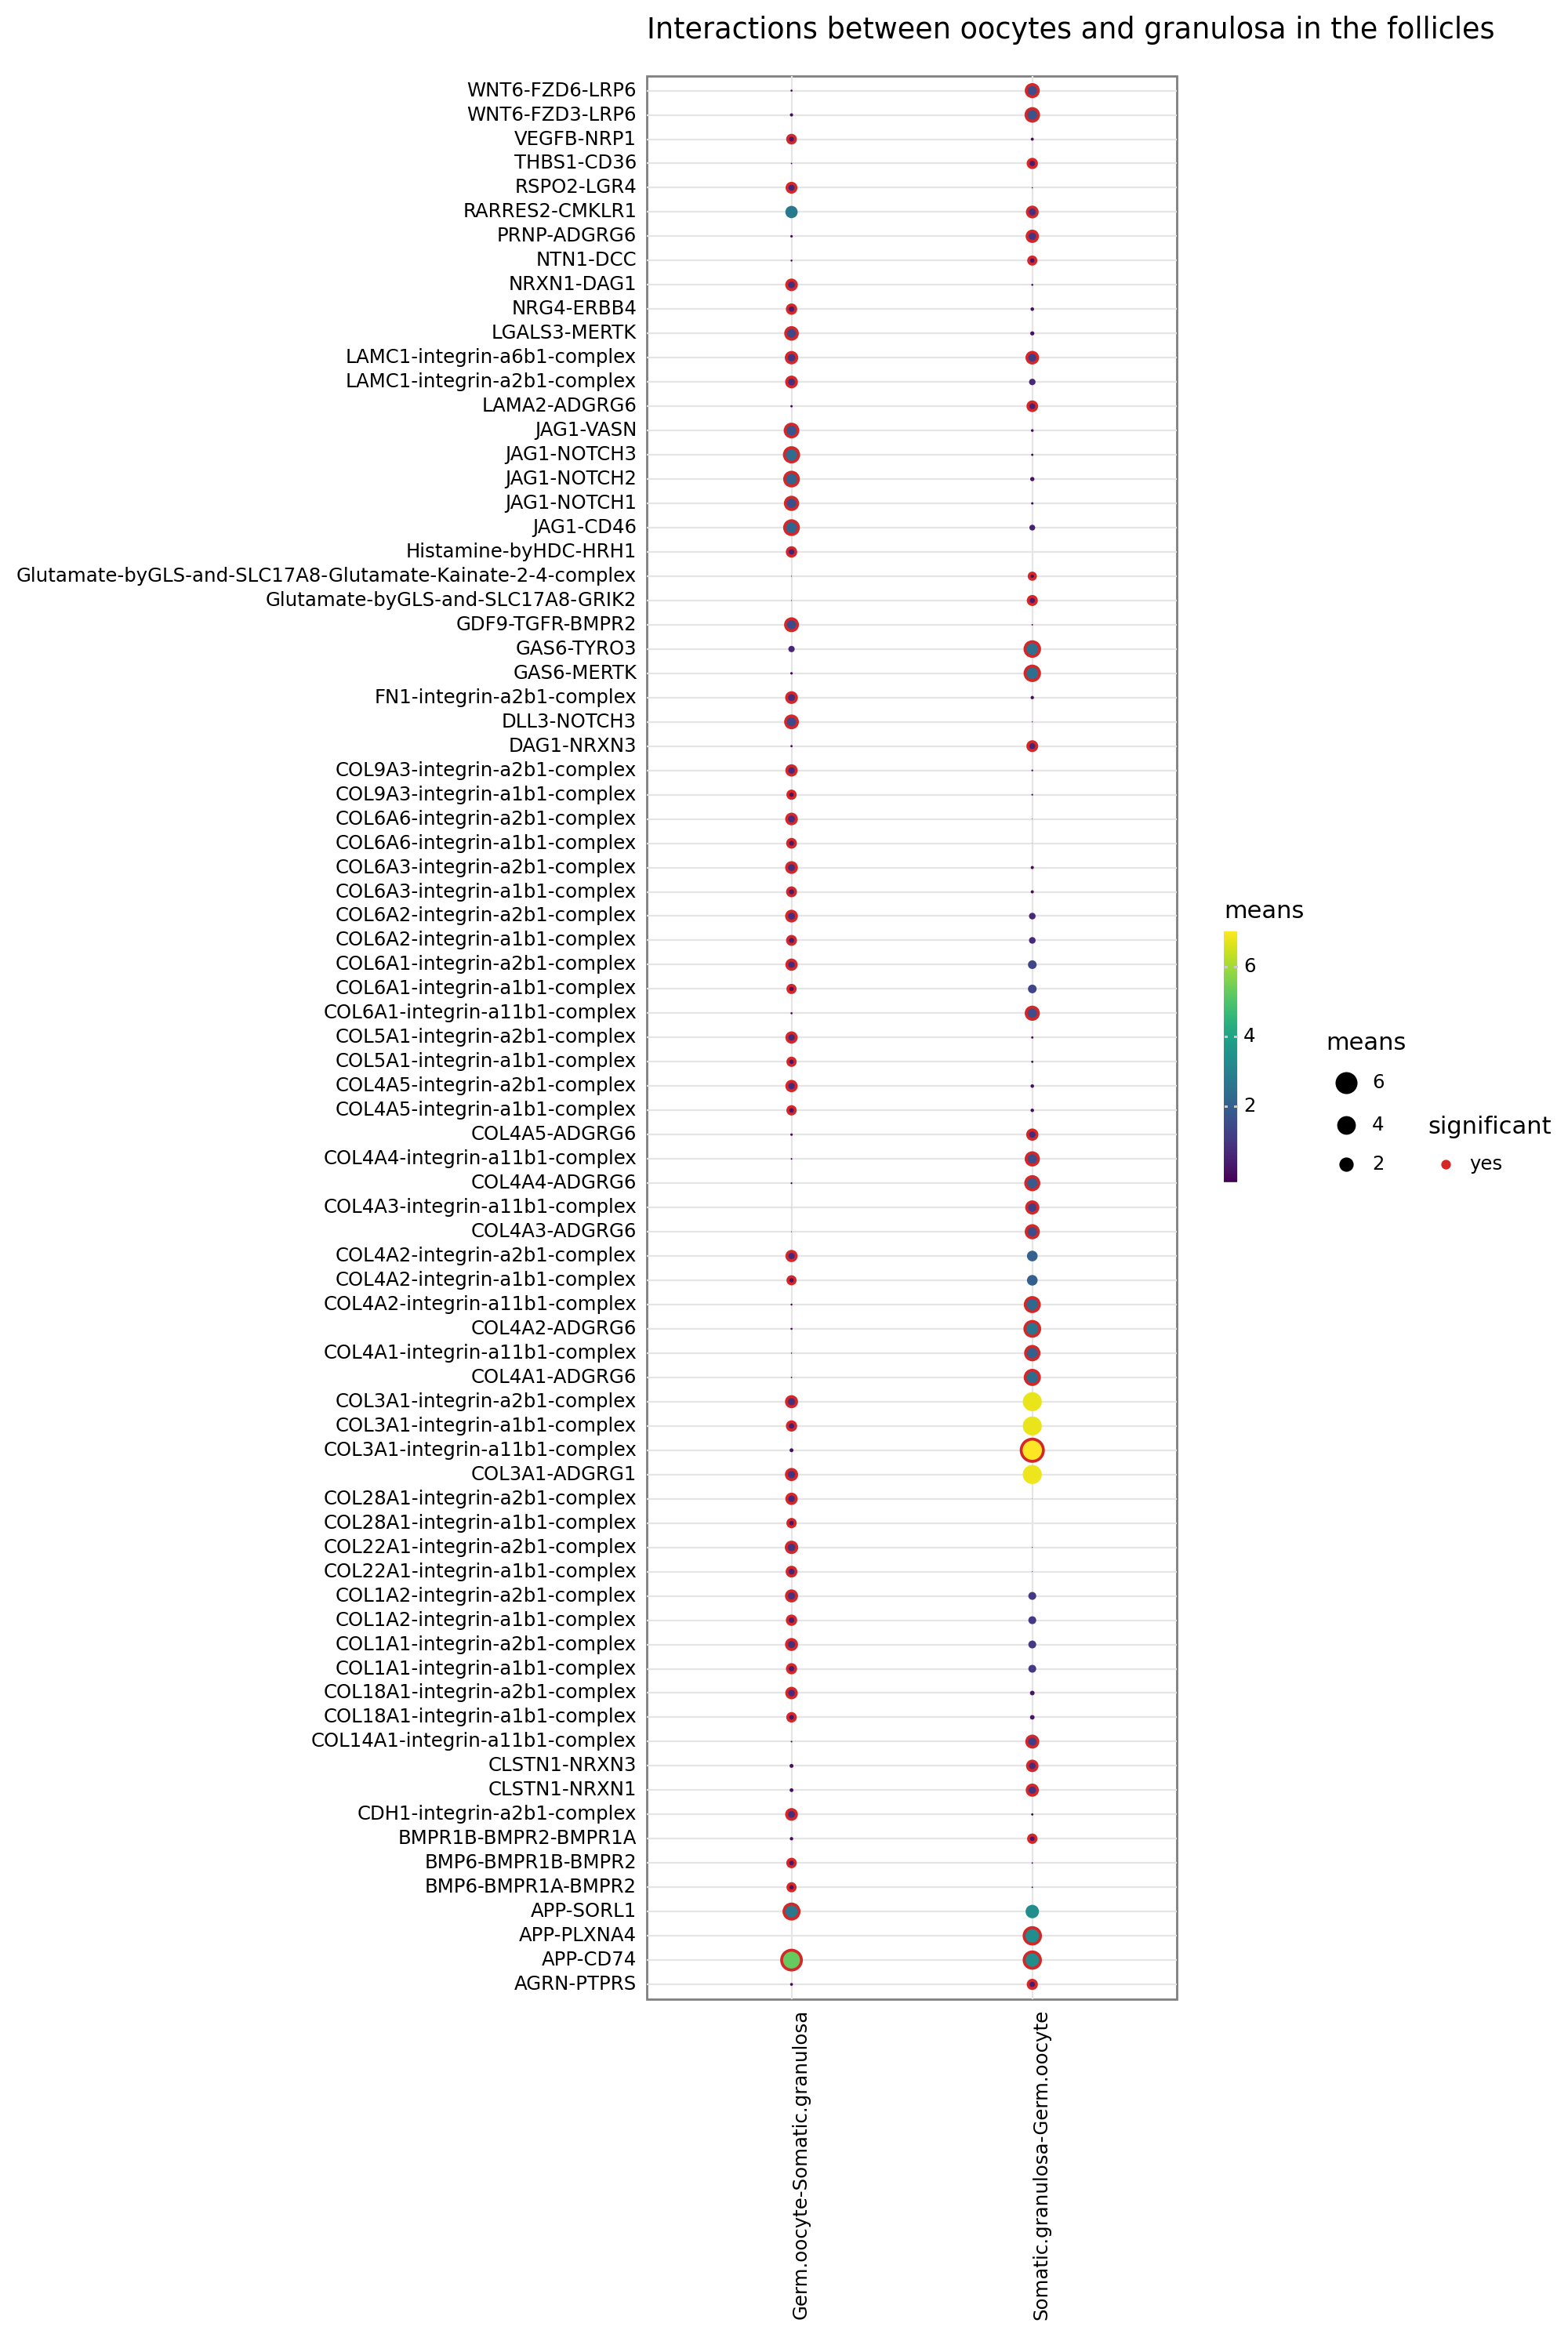

<Figure Size: (1000 x 1500)>

In [20]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Somatic.granulosa",
    cell_type2 = "Germ.oocyte", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
#     genes = ["JAG1"],
    figsize = (10,15),
    title = "Interactions between oocytes and granulosa in the follicles",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False,
#     interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

Now, let's restrict the interactions to those supported by active TFs downstream the receptor (CellSign analysis).

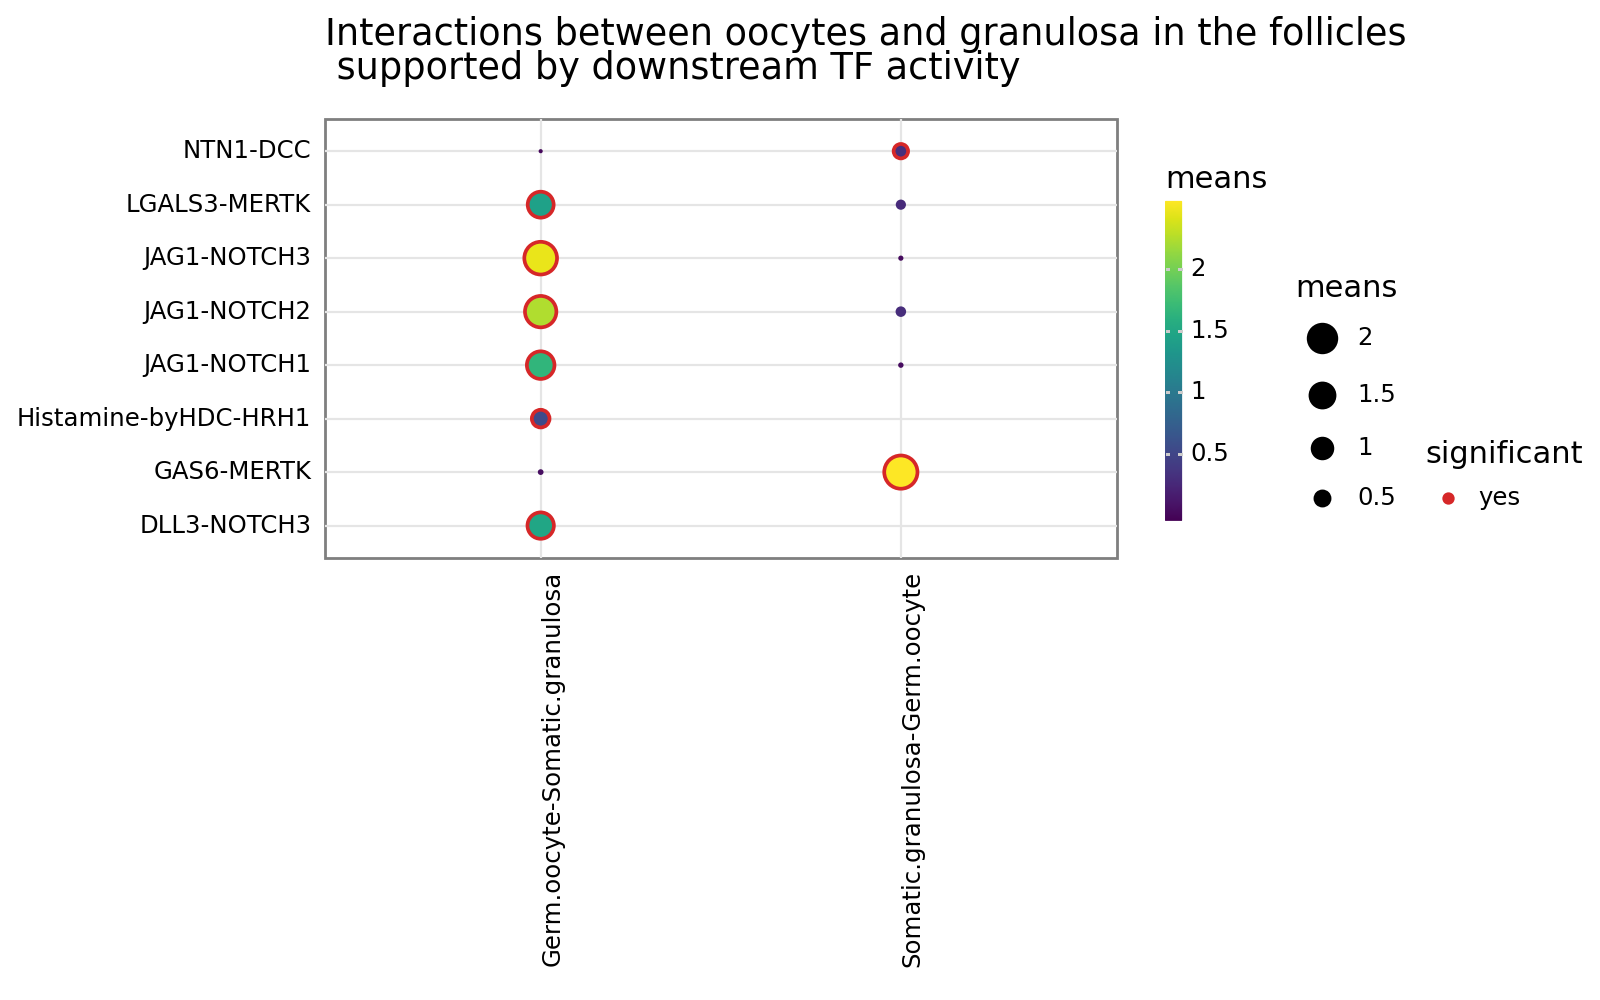

<Figure Size: (800 x 500)>

In [21]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Somatic.granulosa",
    cell_type2 = "Germ.oocyte", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    figsize = (8, 5),
    title = "Interactions between oocytes and granulosa in the follicles \n supported by downstream TF activity",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False,
    cellsign = cpdb_results['CellSign_active_interactions'],
    filter_by_cellsign = True,
    scale_alpha_by_cellsign = False
)

> These are the interactions supported by dowstream TF activity. Now we have more evidence that these receptors are binding their ligands and triggering a downstream response. Now, let's retrieve some pathway information to give more context.


Interactions can also be plotted grouped by pathway.

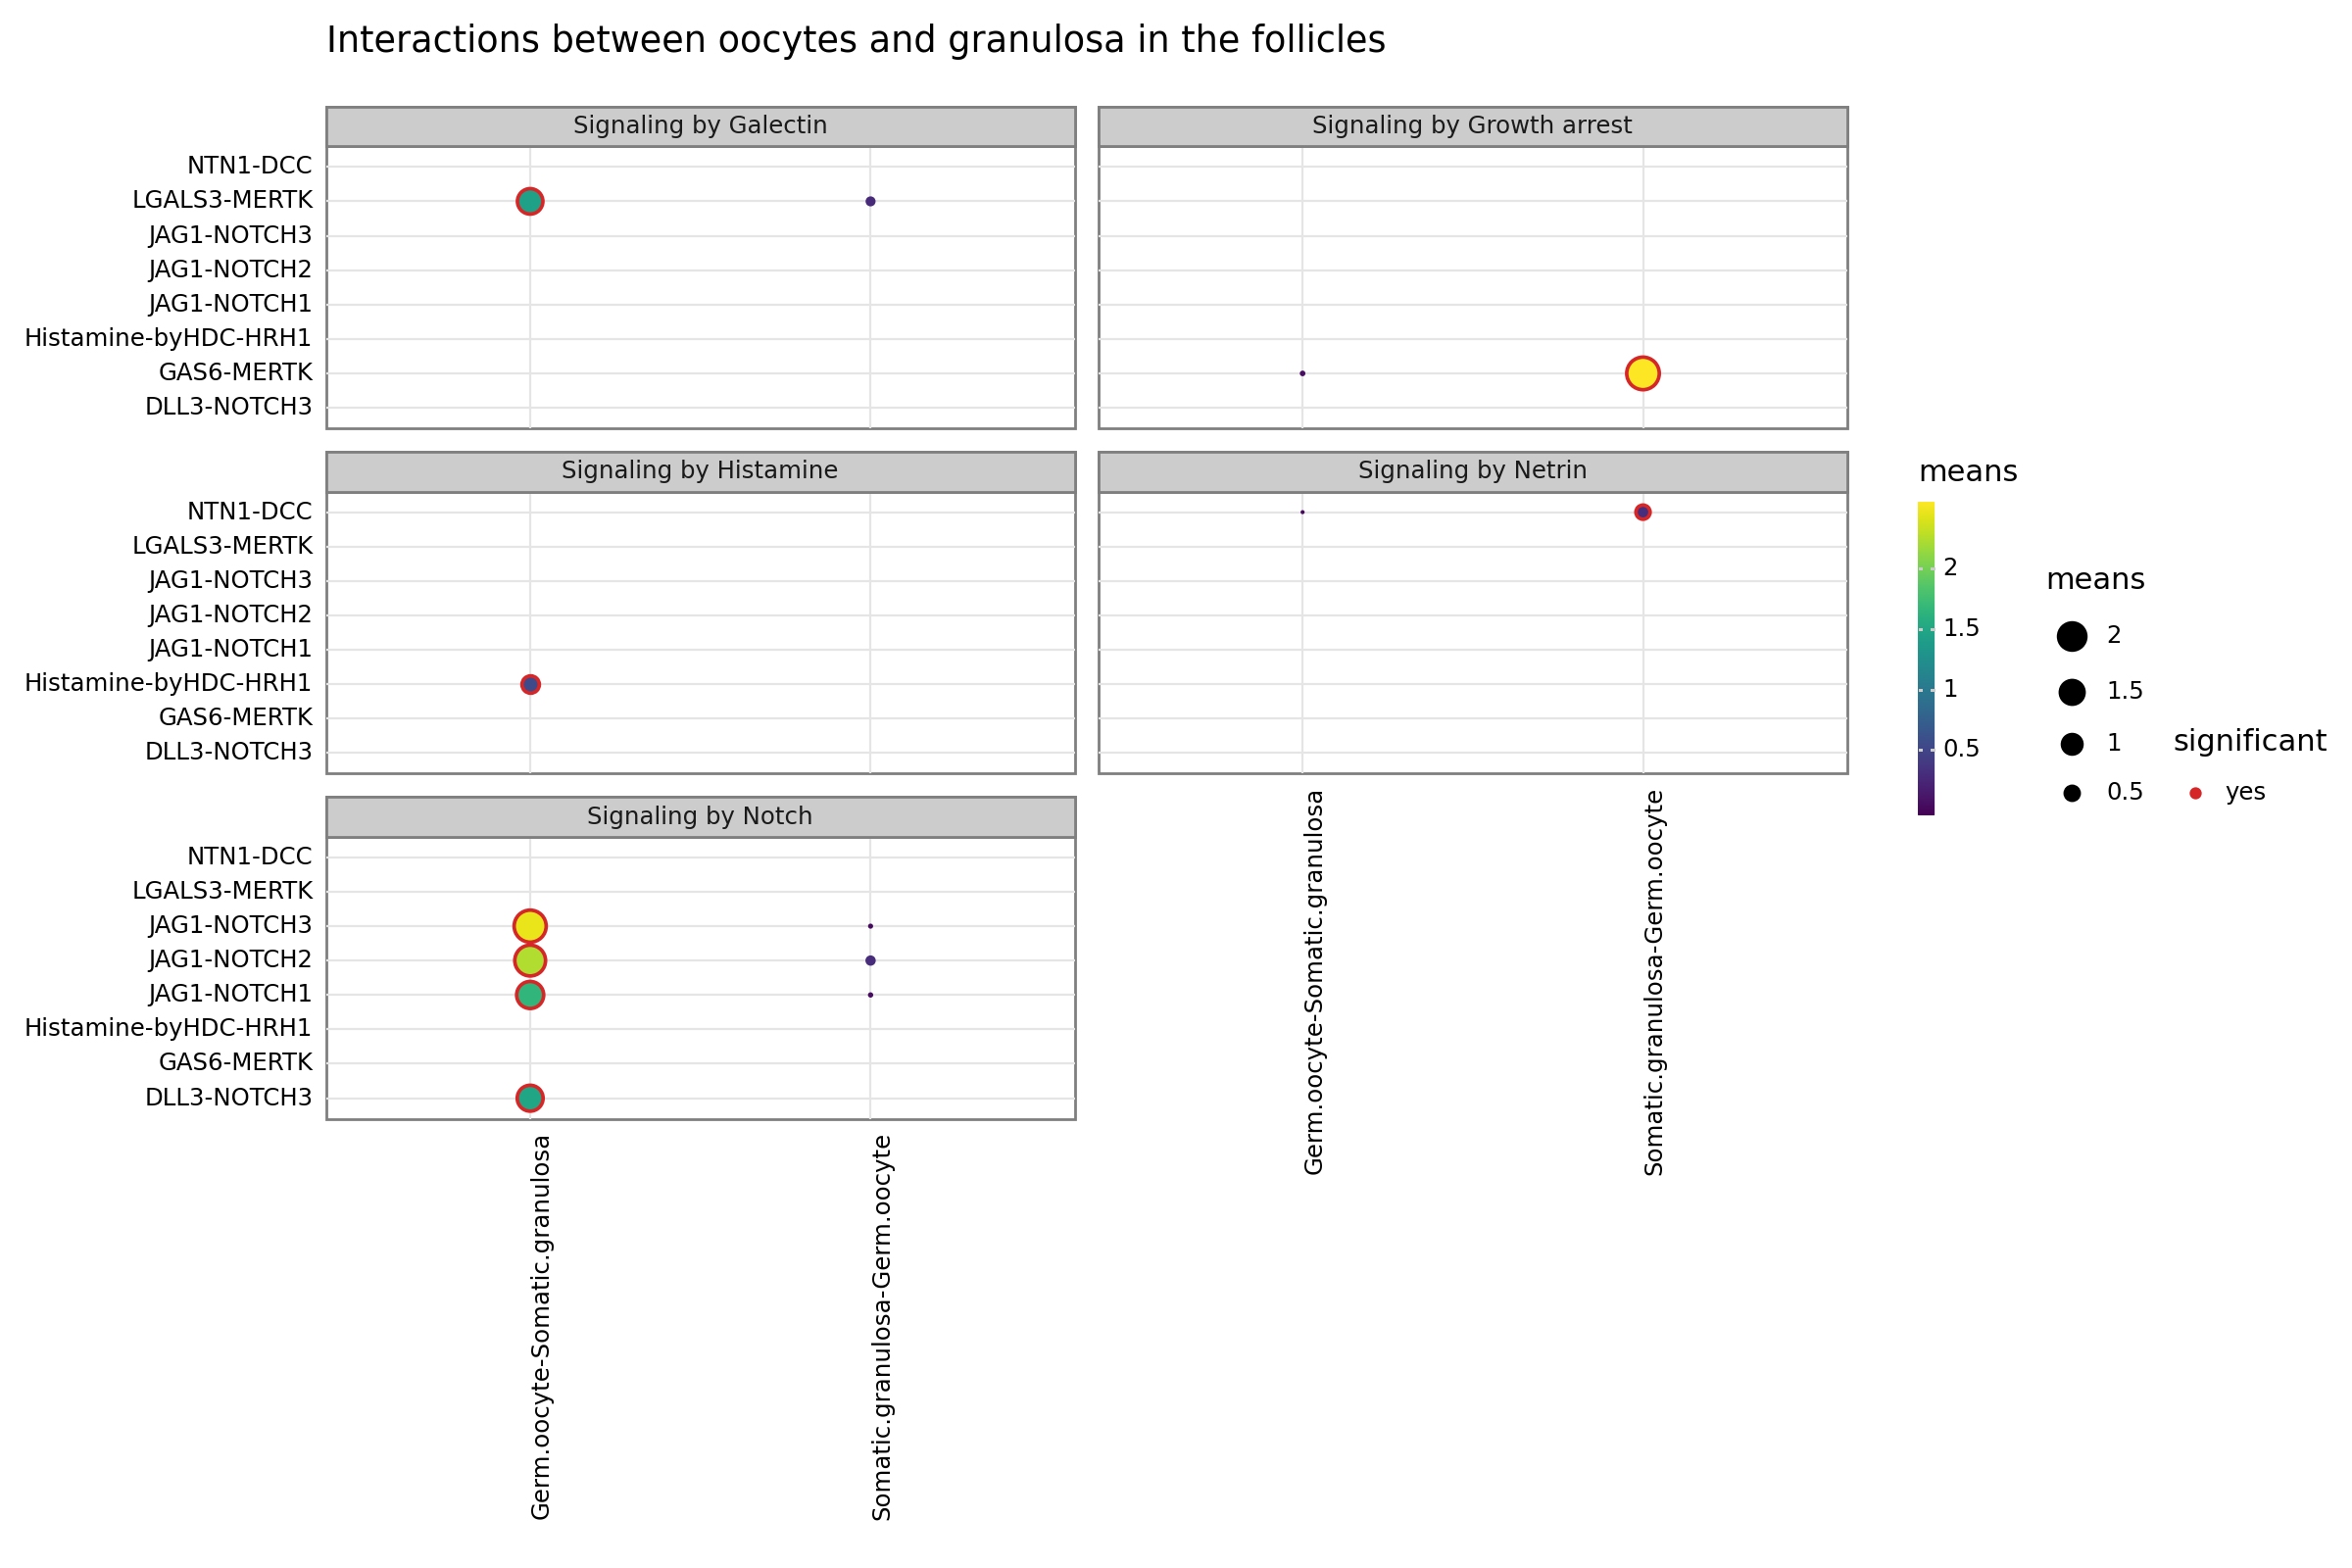

<Figure Size: (1200 x 800)>

In [22]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Somatic.granulosa",
    cell_type2 = "Germ.oocyte", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
#     genes = ["JAG1"],
    figsize = (12, 8),
    title = "Interactions between oocytes and granulosa in the follicles",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False,
    cellsign = cpdb_results['CellSign_active_interactions'],
    filter_by_cellsign = True,
    scale_alpha_by_cellsign = False
)

p + facet_wrap("~ classification", ncol = 2)

Or alternatively we can plot all the interactions where a gene is involved.

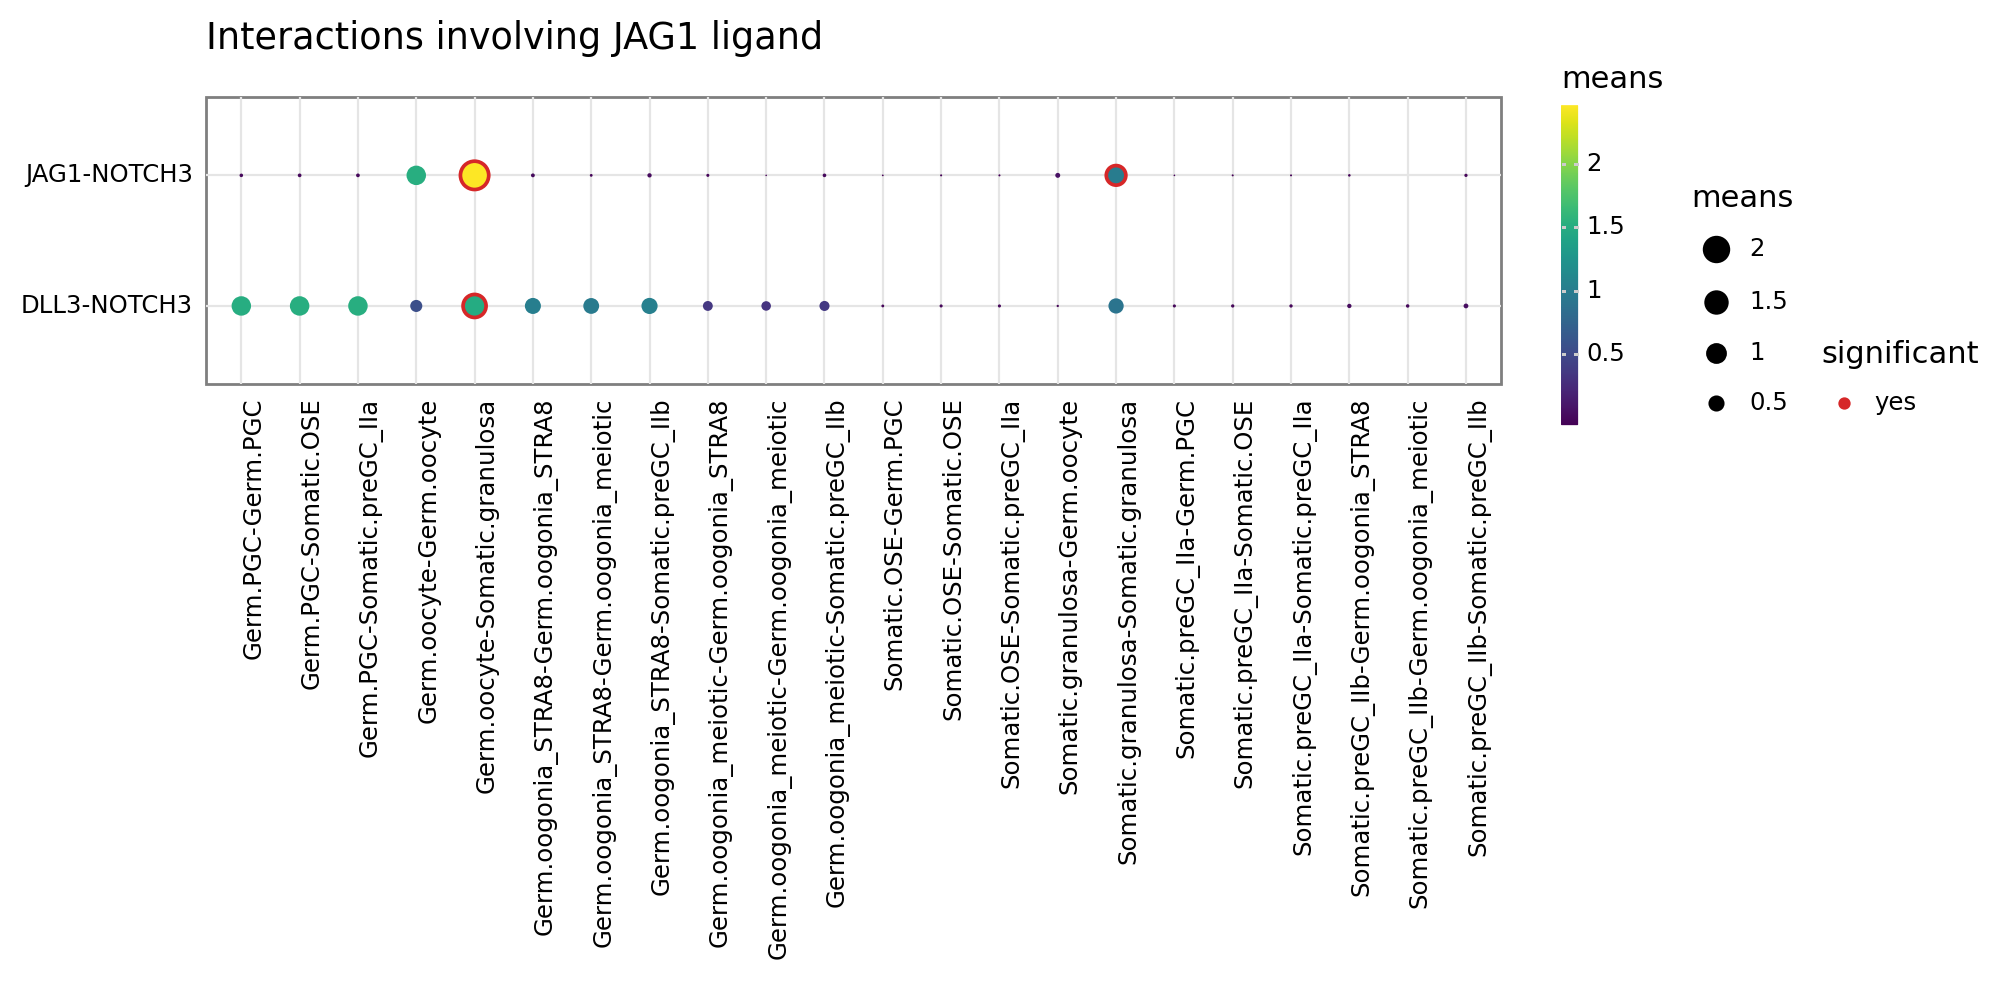

<Figure Size: (1000 x 500)>

In [31]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = ".",
    cell_type2 = ".", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    genes = ["NOTCH3"],
    figsize = (10,5),
    title = "Interactions involving JAG1 ligand",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False
)

> This is telling us that JAG1 interactions are exlusive to the cells in the follicles niche

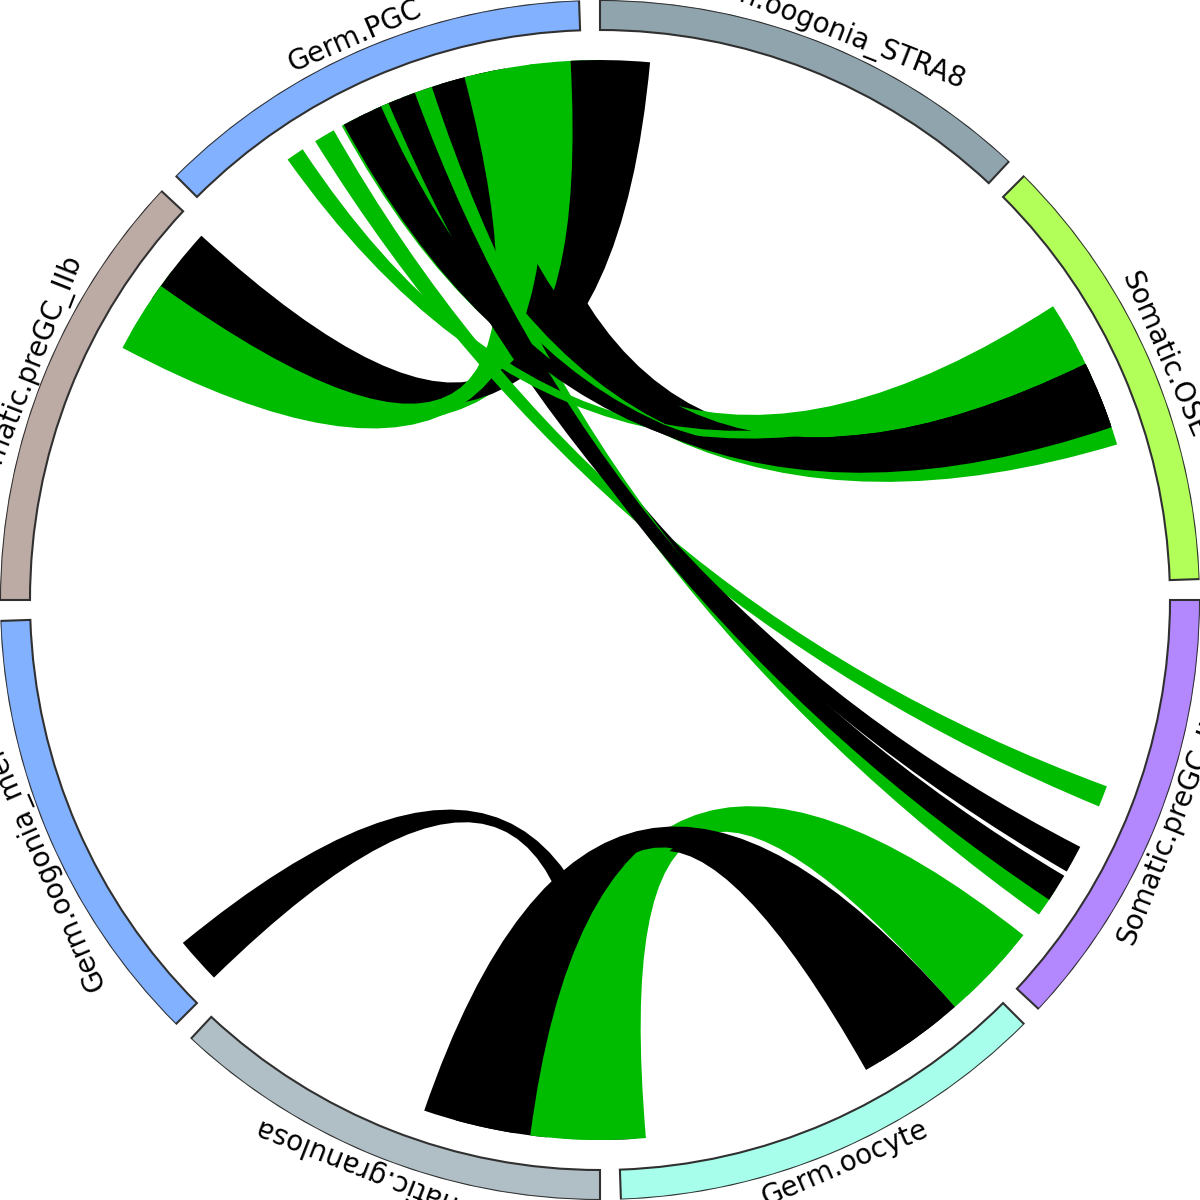

In [32]:
kpy.plot_cpdb_chord(
    adata = adata,
    cell_type1 = ".",
    cell_type2 = ".", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    deconvoluted = cpdb_results['deconvoluted'],
    genes=["NOTCH3"],
    figsize=(6, 6),
    labelposition=50,
)

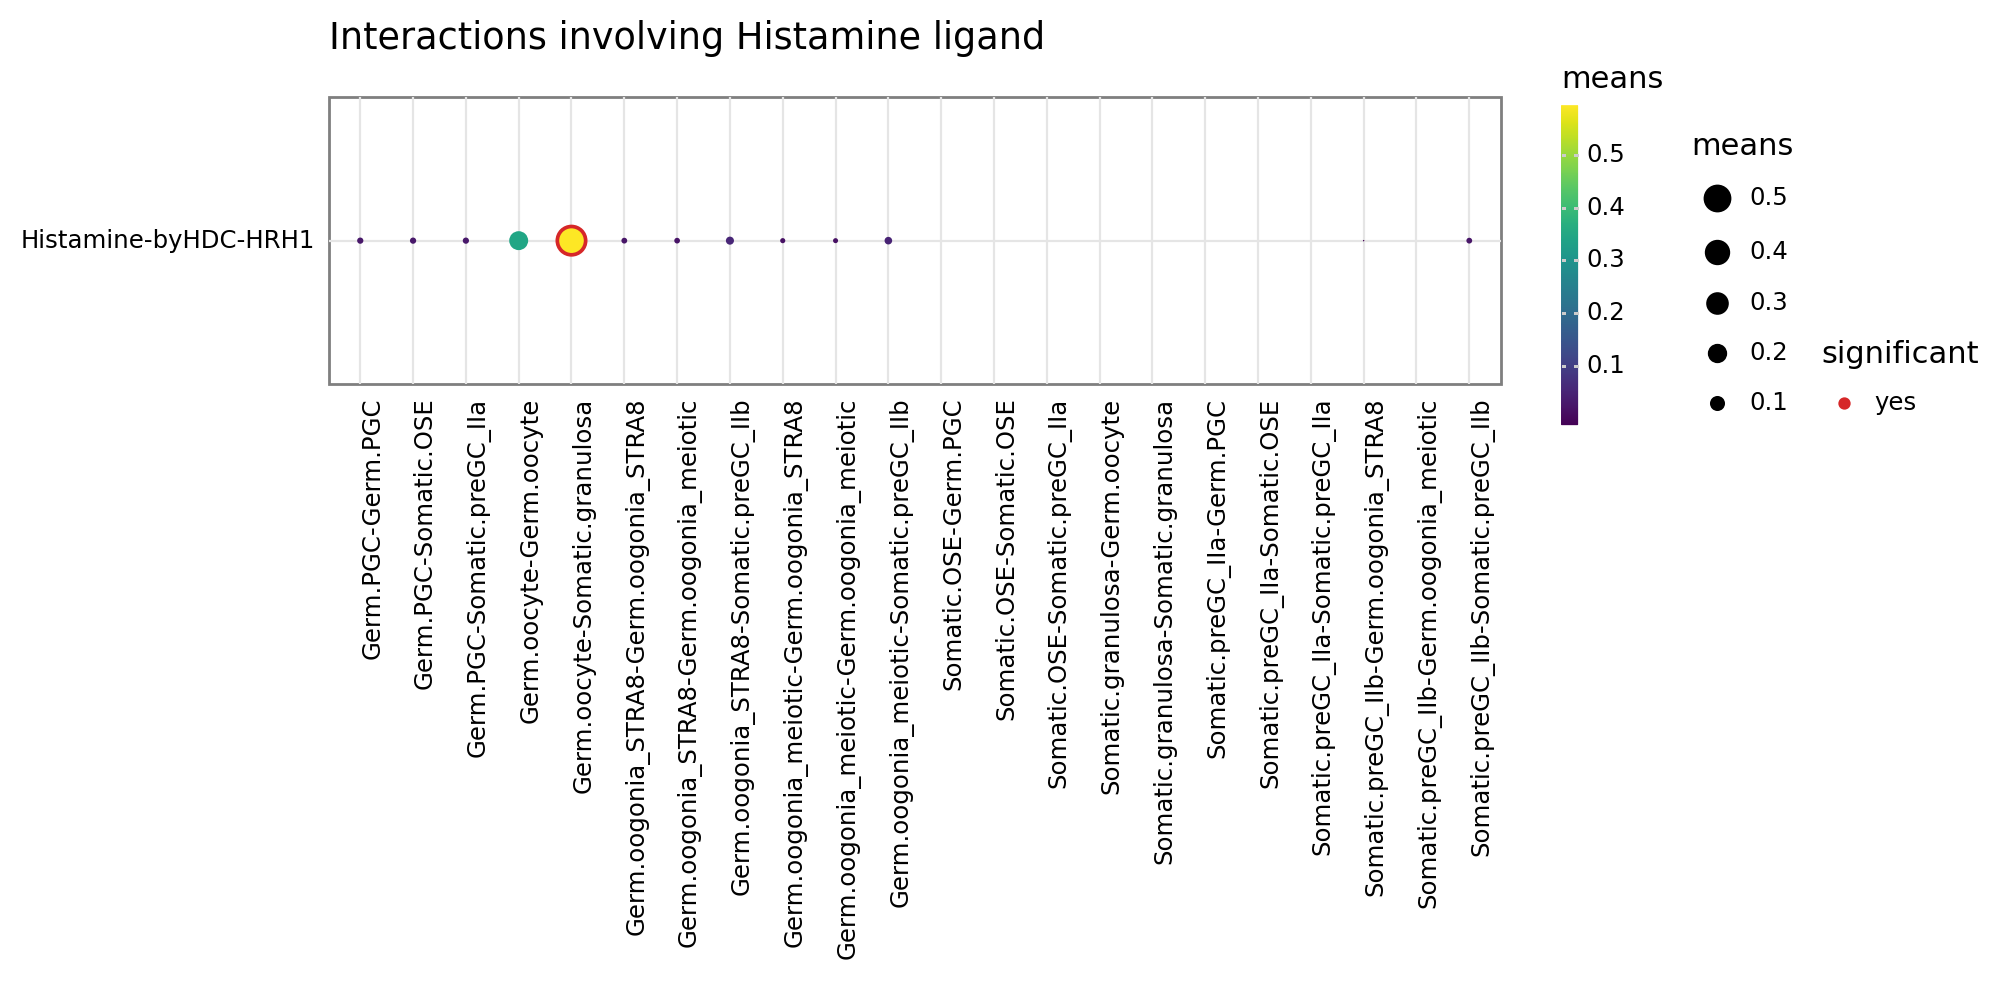

<Figure Size: (1000 x 500)>

In [25]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = ".",
    cell_type2 = ".", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    genes = ["HDC"],
    figsize = (10,5),
    title = "Interactions involving Histamine ligand",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False
)

/opt/conda/envs/cpdb_v500/lib/python3.8/site-packages/scipy/sparse/_base.py:651: RuntimeWarning: divide by zero encountered in divide


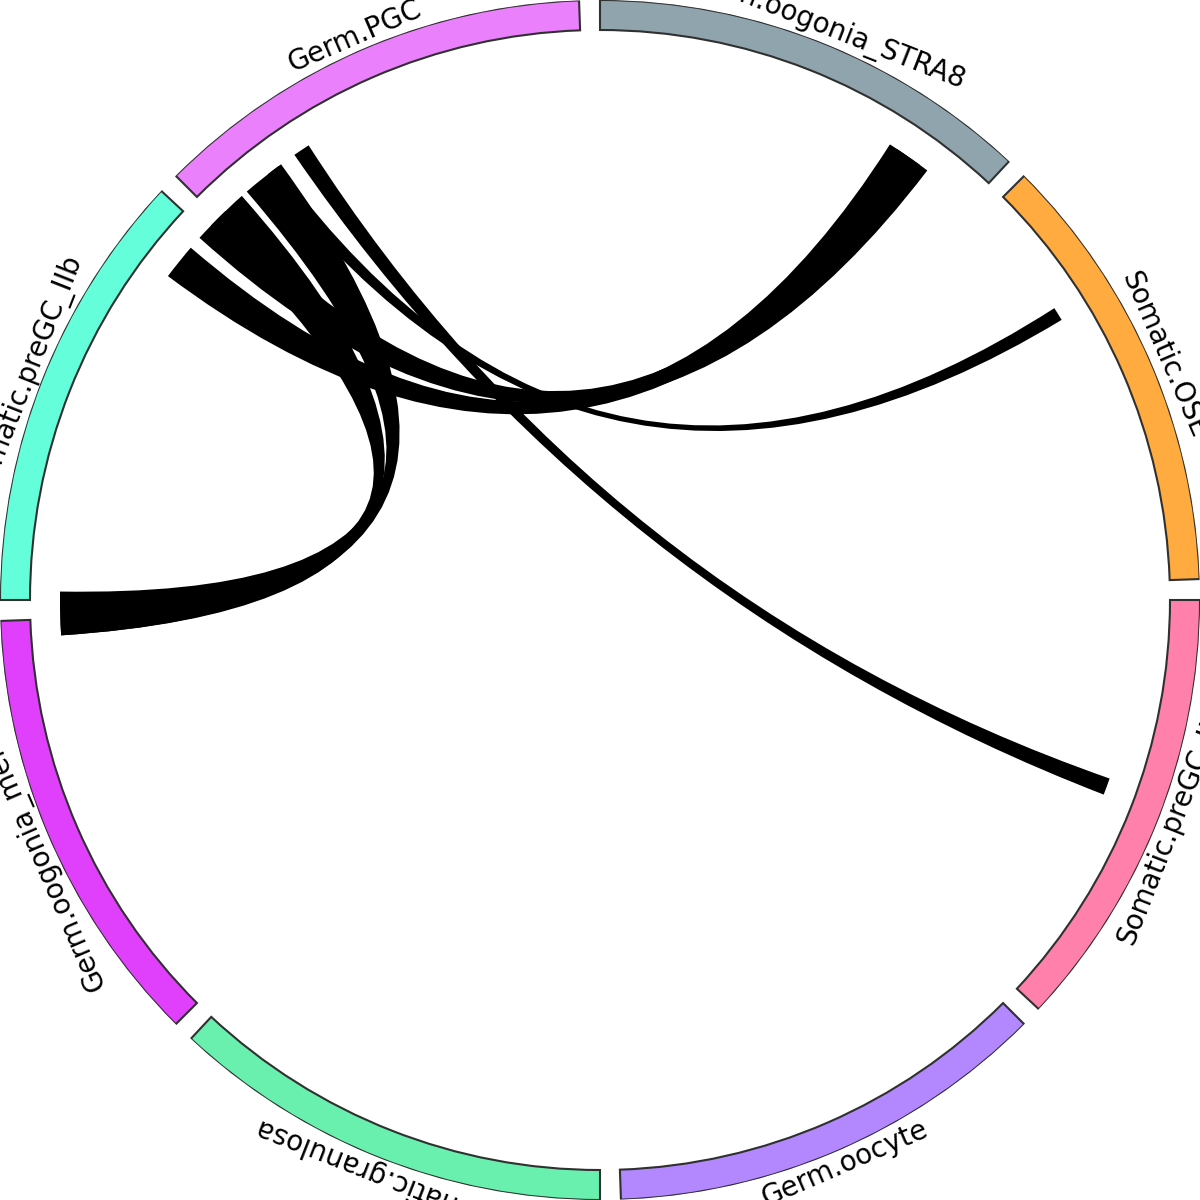

In [29]:
kpy.plot_cpdb_chord(
    adata = adata,
    cell_type1 = ".",
    cell_type2 = ".", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    deconvoluted = cpdb_results['deconvoluted'],
    genes=["HDC"],
    figsize=(6, 6),
    labelposition=50,
)